In [6]:
# General information
classes = ['Background', 'Esophagus', 'Heart', 'Trachea', 'Aorta']
metrics = ['dice', 'sensitivity', 'specificity', 'hausdorff', 'iou', 'precision', 'volumetric', 'VOE']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import numpy as np

# import the metric results
result_location = '../results_metrics/samed/metrics2d/bestweights_samed_1024_r4_augment_no_normalize_no'
metrics = pd.read_csv(result_location + '/test_metrics.csv', header=0)


## Create a barplot for the different organs

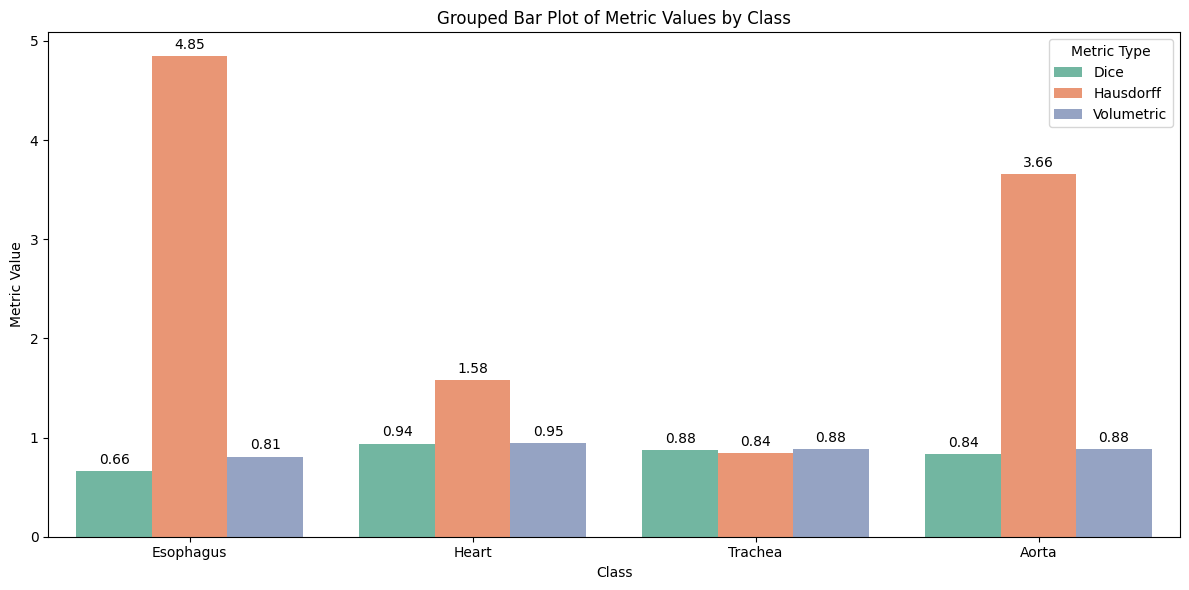

In [30]:
# Make a subset of the metrics
subset_metrics = ['Dice', 'Volumetric', 'Hausdorff']

# Make a subset of the classes
subset_classes = ['Esophagus', 'Heart', 'Trachea', 'Aorta']

# First filter the dataframe for only the subset of metrics and the subset of classes
metrics_subset = metrics[(metrics['class'].isin(subset_classes)) & (metrics['metric_type'].isin(subset_metrics))]

# Create a grouped bar plot with metric type as hue
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=metrics_subset, x='class', y='metric_value', hue='metric_type', errorbar=None, palette='Set2')

# Add the value labels on top of each bar
for patch in barplot.patches:
    height = patch.get_height()
    if height > 0:
        barplot.annotate(
            format(patch.get_height(), '.2f'),
            (patch.get_x() + patch.get_width() / 2., patch.get_height()),
            ha='center', va='bottom',
            fontsize=10, color='black',
            xytext=(0, 3),
            textcoords='offset points'
        )

# Customizing the plot
plt.title('Grouped Bar Plot of Metric Values by Class')
plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.legend(title='Metric Type', loc='upper right')
plt.tight_layout()
plt.show()

## Create a slice by slice segmentation quality plots

In [24]:
def interpolate_slices(df, num_slices=100):
    results = []
    for (patient, cls, metric), group in df.groupby(['patient_id','class', 'metric_type']):
        # Create interpolation function
        normalized_slices = (group['slice_name'] - group['slice_name'].min()) / (group['slice_name'].max() - group['slice_name'].min())
        interp_func = np.interp(
            np.linspace(0, 1, num_slices), # Interpolating on a common scale
            normalized_slices, # Slices are normalized to [0, 1]
            group['metric_value']
        )
        # Store results with interpolated values
        for i, metric_value in enumerate(interp_func):
            results.append({
                'patient_id': patient,
                'slice_percentage': i / num_slices,
                'class': cls,
                'metric_type': metric,
                'metric_value': metric_value
            })
    return pd.DataFrame(results)

interpolated_metrics = interpolate_slices(metrics, num_slices=100)

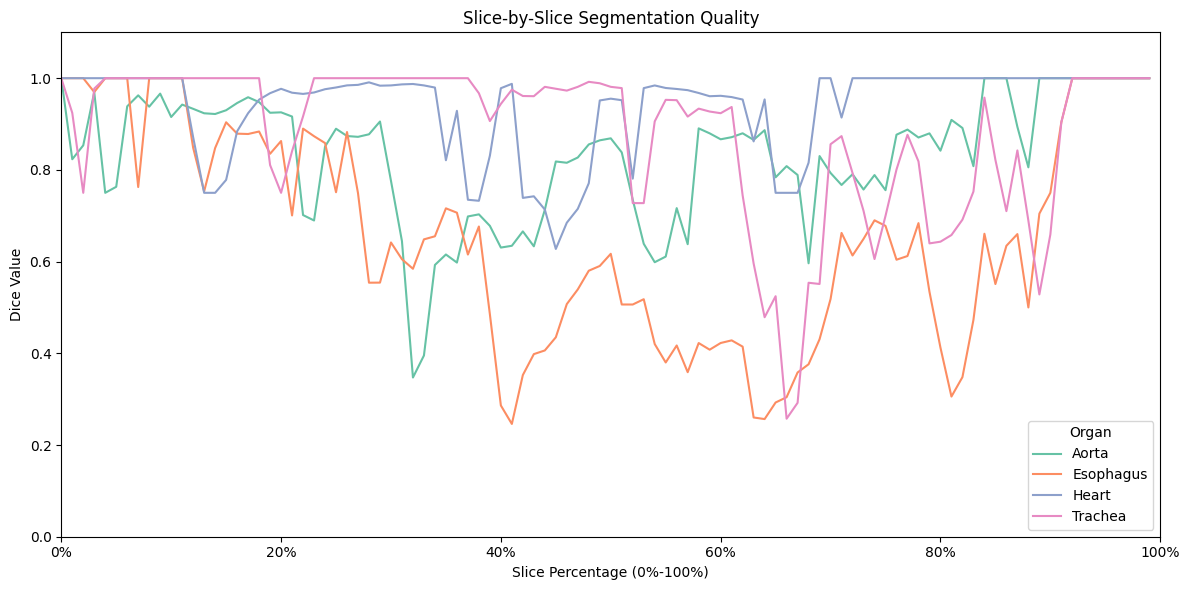

In [26]:
# Plotting the interpolated slice-by-slice segmentation quality
specific_metric = 'Dice'

# Filter the dataframe for the specific metric
slice_plot_df = interpolated_metrics[interpolated_metrics['metric_type'] == specific_metric]


plt.figure(figsize=(12, 6))
sns.lineplot(data=slice_plot_df, x='slice_percentage', y='metric_value', hue='class', markers=False, errorbar=None, palette='Set2')

# Customize plot
plt.title('Slice-by-Slice Segmentation Quality')
plt.xlabel(r'Slice Percentage (0%-100%)')
plt.xticks(np.linspace(0, 1, 6), [f'{int(x*100)}%' for x in np.linspace(0, 1, 6)])
plt.ylabel(f"{specific_metric} Value")
plt.legend(title='Organ', loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, slice_plot_df['metric_value'].max() * 1.1)
plt.tight_layout()
plt.show()

## Create a violon plot

2.3752968e-12
1.0


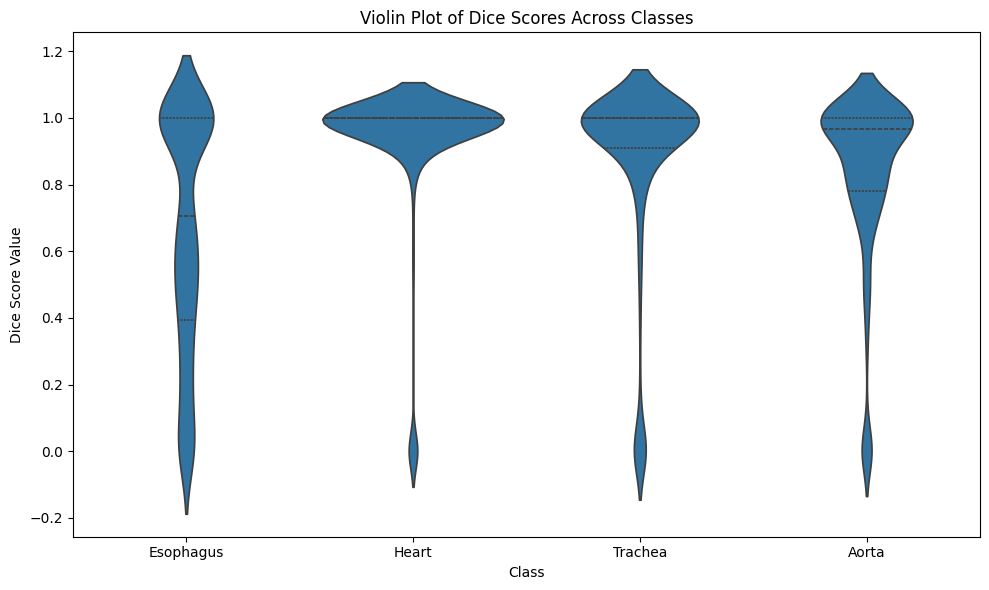

In [31]:
metric_type = 'Dice'

# Assuming 'df' has the following columns: ['patient_id', 'slice_name', 'class', 'metric_type', 'metric_value']

# Filter the DataFrame for the specific metric type, e.g., 'Dice'
metrics_subset = metrics[metrics['metric_type'] == metric_type]
print(metrics_subset['metric_value'].min())
print(metrics_subset['metric_value'].max())

plt.figure(figsize=(10, 6))

# Creating the violin plot for the filtered data
sns.violinplot(data=metrics_subset, x='class', y='metric_value', inner='quartile')

# Customize plot
plt.title('Violin Plot of Dice Scores Across Classes')
plt.xlabel('Class')
plt.ylabel('Dice Score Value')
plt.yscale('linear')

# Display the plot
plt.tight_layout()
plt.show()
